In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA, ARIMA
plt.style.use("fivethirtyeight")

In [2]:
listings = pd.read_csv("data/listings.csv")
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,5570,https://www.airbnb.com/rooms/5570,20191121092222,2019-11-21,Ocean front condo on the sand,Missionbeachretreat. Great Ocean Front Condo...,This charming two bedroom beachfront condomini...,Missionbeachretreat. Great Ocean Front Condo...,none,While some may compare San Diego’s Mission Bea...,...,f,f,strict_14_with_grace_period,f,f,2,2,0,0,NaN
1,8488,https://www.airbnb.com/rooms/8488,20191121092222,2019-11-21,Juniper Zen Palace- SD's Best Hood!,Walk every where in San Diegos most charming a...,Private craftsman home in the heart of Histori...,Walk every where in San Diegos most charming a...,none,South Park is a charming community and our nei...,...,f,f,strict_14_with_grace_period,t,t,2,2,0,0,0.36
2,29967,https://www.airbnb.com/rooms/29967,20191121092222,2019-11-21,"Great home, 10 min walk to Beach","This 2 bedroom, 2 full bathroom home offers al...","This two bedroom (1 CA king bed, 1 queen bed),...","This 2 bedroom, 2 full bathroom home offers al...",none,NaN,...,f,f,moderate,f,f,5,5,0,0,0.53
3,38245,https://www.airbnb.com/rooms/38245,20191121092222,2019-11-21,Point Loma/Liberty Station-NTC,Stay in a 1928 Spanish Style home. Den is dow...,Please note: 1928 home; remodeled in 2015. Co...,Stay in a 1928 Spanish Style home. Den is dow...,none,"This neighborhood is an expensive, high-end Po...",...,f,f,moderate,t,t,3,0,3,0,1.28
4,39516,https://www.airbnb.com/rooms/39516,20191121092222,2019-11-21,Art Studio Retreat/Rustic Cabin,We love having explorers from all over the wor...,"Nestled in South/North Park, a gentrified neig...",We love having explorers from all over the wor...,none,"We love our eclectic neighborhood, with a smal...",...,f,f,strict_14_with_grace_period,t,f,1,1,0,0,3.38


In [3]:
calendar = pd.read_csv("data/calendar.csv")
calendar["date"] = pd.to_datetime(calendar["date"])
parse_price = lambda p: float(p.replace(",", "")[1:])
calendar["price"] = calendar["price"].apply(parse_price)
calendar["adjusted_price"] = calendar["adjusted_price"].apply(parse_price)
calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,5570,2019-11-21,f,2050.0,2050.0,3,365
1,5570,2019-11-22,f,2050.0,2050.0,3,365
2,5570,2019-11-23,f,2050.0,2050.0,3,365
3,5570,2019-11-24,f,2050.0,2050.0,3,365
4,5570,2019-11-25,f,2050.0,2050.0,3,365


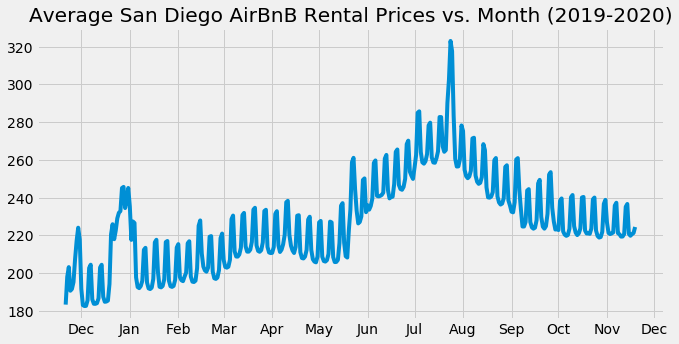

In [4]:
fig = plt.figure(figsize=(10, 5))
months = mdates.MonthLocator()
months_fmt = mdates.DateFormatter('%b')
plt.gca().xaxis.set_major_locator(months)
plt.gca().xaxis.set_major_formatter(months_fmt)
plt.title("Average San Diego AirBnB Rental Prices vs. Month (2019-2020)")

# Create and plot time series
avg_prices = calendar.groupby("date").mean()["price"]
plt.plot(avg_prices.index, avg_prices)
plt.savefig("plots/averagePrice.png")

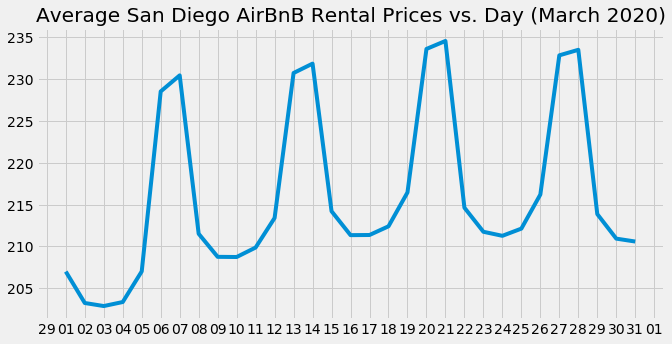

In [5]:
fig = plt.figure(figsize=(10, 5))
days = mdates.DayLocator()
days_fmt = mdates.DateFormatter('%d')
plt.gca().xaxis.set_major_locator(days)
plt.gca().xaxis.set_major_formatter(days_fmt)
avg_prices = calendar.groupby("date").mean()["price"]
plt.title("Average San Diego AirBnB Rental Prices vs. Day (March 2020)")

# Create and plot time series of prices in march
march_prices = avg_prices[avg_prices.index.month == 3]
plt.plot(march_prices.index, march_prices);

plt.savefig("plots/averagePrice.png")

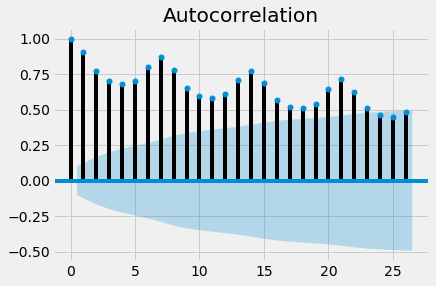

In [6]:
plot_acf(avg_prices.iloc[:]);

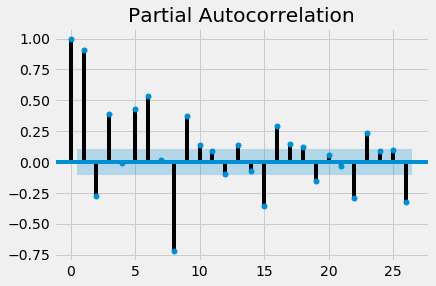

In [7]:
plot_pacf(avg_prices.iloc[:]);

In [8]:
deltas = avg_prices.index - pd.DatetimeIndex([datetime.date(2020, 10, 1) for x in range(len(avg_prices))])
train_part = avg_prices[deltas.days < 0]
test_part = avg_prices[~(deltas.days < 0)]

In [9]:
train_part.tail()

date
2020-09-26    253.467217
2020-09-27    234.605127
2020-09-28    227.417047
2020-09-29    223.048475
2020-09-30    223.340725
Name: price, dtype: float64

In [10]:
test_part.head()

date
2020-10-01    222.791513
2020-10-02    238.229704
2020-10-03    239.538898
2020-10-04    222.023206
2020-10-05    220.352659
Name: price, dtype: float64

In [11]:
calculate_rmse = lambda res: np.sqrt((res.resid ** 2).sum()/(len(res.resid) - 1))

/home/tmittal/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/tmittal/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/tmittal/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/tmittal/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/tmittal/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be 

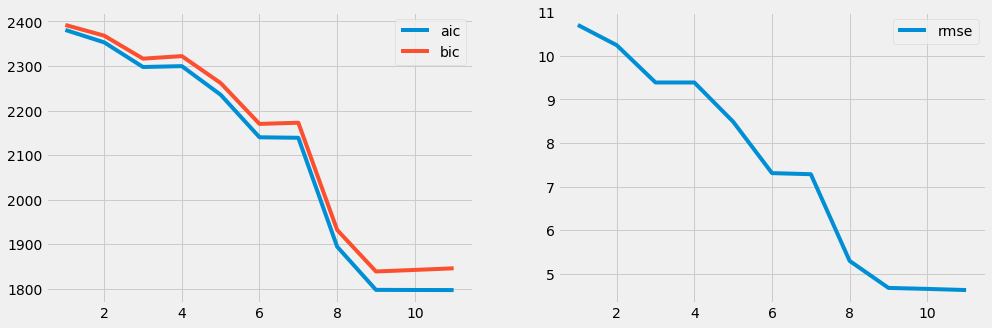

In [12]:
ar_search = pd.DataFrame(columns=["aic", "bic", "rmse"])
for i in range(1, 12):
    arma_model = ARMA(train_part, order=(i,0))
    arma_res = arma_model.fit()
    ar_search.loc[i] = (arma_res.aic, arma_res.bic, calculate_rmse(arma_res))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ar_search.plot(y=["aic", "bic"], ax=ax1)
ar_search.plot(y="rmse", ax=ax2);

In [13]:
ar_model = ARMA(train_part, order=(9, 0))
ar_res = ar_model.fit()

/home/tmittal/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


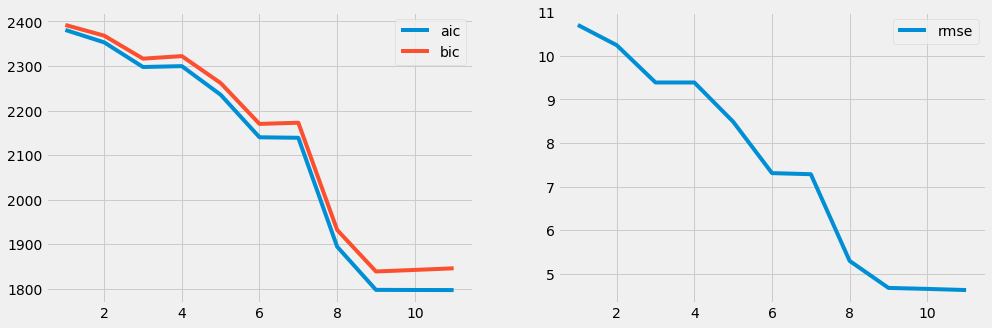

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ar_search.plot(y=["aic", "bic"], ax=ax1)
ar_search.plot(y="rmse", ax=ax2);

/home/tmittal/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/tmittal/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/tmittal/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/tmittal/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/tmittal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "

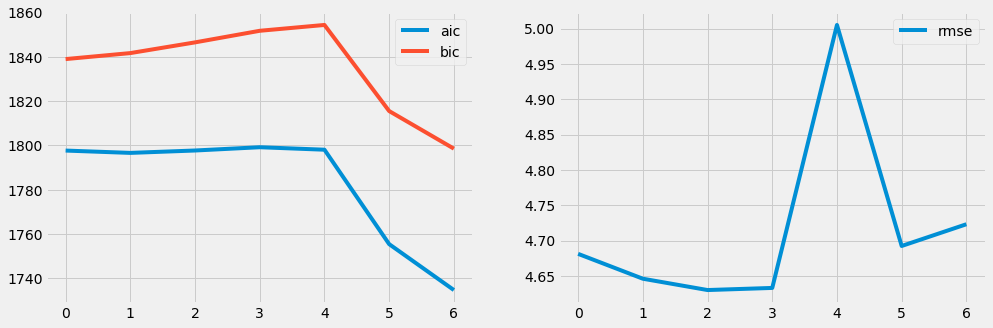

In [15]:
ma_search = pd.DataFrame(columns=["aic", "bic", "rmse"])
# Anything that is 7 or higher throws an error due to the series being non stationary past a week
for i in range(7):
    arma_model = ARMA(train_part, order=(9,i))
    arma_res = arma_model.fit()
    ma_search.loc[i] = (arma_res.aic, arma_res.bic, calculate_rmse(arma_res))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ma_search.plot(y=["aic", "bic"], ax=ax1)
ma_search.plot(y="rmse", ax=ax2);

In [16]:
# Best params from grid search
arma_model = ARMA(train_part, order=(9,6))
arma_res = arma_model.fit()

/home/tmittal/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/tmittal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/tmittal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/home/tmittal/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/tmittal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/tmittal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/tmittal/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/tmittal/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D

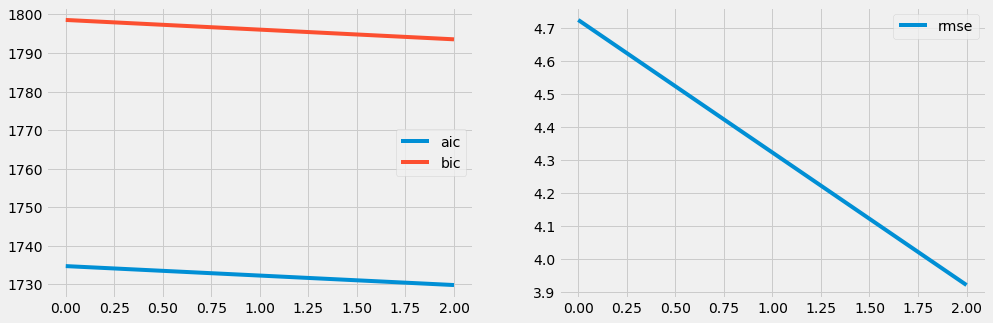

In [17]:
diff_search = pd.DataFrame(columns=["aic", "bic", "rmse"])
for i in [0, 2]:
    arima_model = ARIMA(train_part, order=(9, i, 6))
    arima_res = arima_model.fit()
    diff_search.loc[i] = (arima_res.aic, arima_res.bic, calculate_rmse(arima_res))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
diff_search.plot(y=["aic", "bic"], ax=ax1)
diff_search.plot(y="rmse", ax=ax2);

In [18]:
# Best params from grid search
arima_model = ARIMA(train_part, order=(9,2,6))
arima_res = arima_model.fit()

/home/tmittal/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/tmittal/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/tmittal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/tmittal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [19]:
print("AR RMSE:", calculate_rmse(ar_res))
print("ARMA RMSE:", calculate_rmse(arma_res))
print("ARIMA RMSE:", calculate_rmse(arima_res))

AR RMSE: 4.681415037714953
ARMA RMSE: 4.723320704477969
ARIMA RMSE: 3.920433451477796


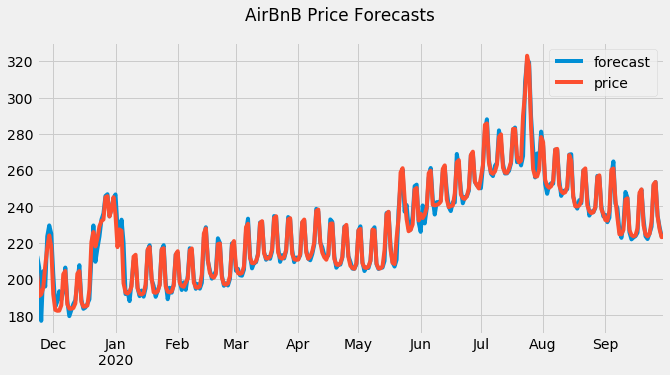

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle("AirBnB Price Forecasts")
arima_res.plot_predict(ax=ax);

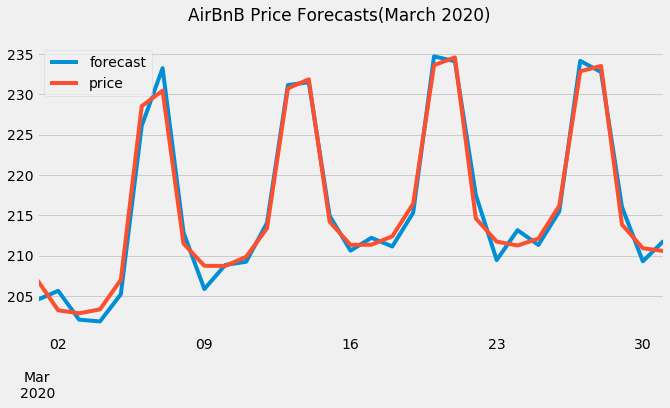

In [21]:
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle("AirBnB Price Forecasts(March 2020)")
arima_res.plot_predict(march_prices.index[0], march_prices.index[-1], ax=ax);

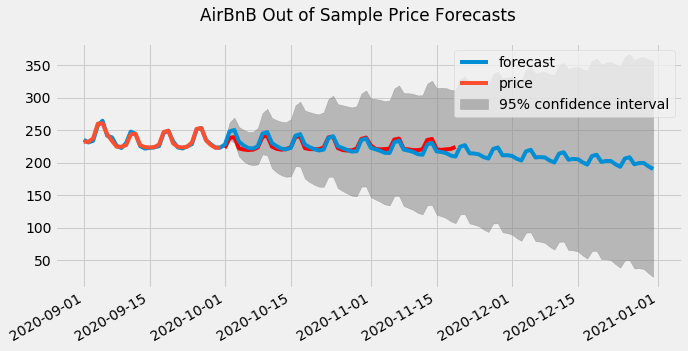

In [22]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(test_part.index, test_part, c='r')
fig.suptitle("AirBnB Out of Sample Price Forecasts")
arima_res.plot_predict(datetime.date(2020, 9, 1), datetime.date(2020, 12, 31), ax=ax);